## RAG Agent

In [ ]:
import json
from langchain import hub
from langchain_core.documents import Document
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate, AIMessagePromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama
from langchain_qdrant import QdrantVectorStore
from langgraph.graph import START, StateGraph
from qdrant_client import QdrantClient
from qdrant_client.models import Filter, FieldCondition, MatchValue
from typing_extensions import List, TypedDict, Annotated, Literal


# set parameters
#---------------------------------------------------------------------------------------
# Qdrant parameters
collection_name = "demo_collection" # name of the Qdrant collection
db_path = "test_rag_db" # path to the Qdrant database

# embedding model parameters
model_name = "sentence-transformers/all-mpnet-base-v2" # embedding model name

# LLM parameters
llm_name = "llama3.1:8b" # name of the LLM model
prompt_extention = "Please provide a detailed answer to the question containing all the information provided in the context." # additional prompt text to get more detailed output
k = 5 # number of documents to retrieve from the RAG database
#---------------------------------------------------------------------------------------

# Load comanies 
with open("companies.json") as f:
    companies = json.load(f)

chat_history = "No history" #TODO load from database

# Define prompt for question-answering
system_message = SystemMessage("You are a helpful AI assistant for question-answering tasks. The provided chat history includes facts about the user you are speaking with.")
history_message = AIMessagePromptTemplate.from_template("Chat history: {chat_history}") 
input_message = HumanMessagePromptTemplate.from_template("""Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
                                                            Question: {question} 
                                                            Context: {context} 
                                                            Answer:""") # create input message

prompt = ChatPromptTemplate.from_messages([system_message, history_message, input_message]) # create prompt template
                                                           
# system_message = SystemMessagePromptTemplate.from_template("""You are a helpful AI assistant for question-answering tasks.
                                                           
#                                                            Information about the user you are talking to:
#                                                            name: {name}
#                                                            environmantal preferences: {environmental_preferences}
#                                                            animal testing preferences: {animal_testing_preferences}
#                                                            local preferences: {local_preferences}
#                                                            company size preferences: {company_size_preferences}
#                                                            """) # create system message using memory
# prompt.messages.insert(0, system_message) # insert system message at the beginning of the prompt

# # Update the input variables of the whole prompt
# prompt.input_variables = [
#     "question",
#     "context",
#     "name",
#     "environmental_preferences",
#     "animal_testing_preferences",
#     "local_preferences",
#     "company_size_preferences"
# ]

class Search(TypedDict):

    query: Annotated[str, ..., "Search query to run."]
    company: Annotated[
        #Literal[tuple(companies.keys())],     # list of all companies in the database (add all companies here), ev also add topic filter
        Literal["Beiersdorf", "L'Oréal"],     # list of all companies in the database (add all companies here), ev also add topic filter
        ...,
        "company to query.",
    ]

# Define state for application
class State(TypedDict):
    chat_history : str
    question: str
    query: Search
    context: List[Document]
    answer: str

# embedding model
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# Define LLM for question-answering
llm = ChatOllama(model=llm_name)

# Initialize the Qdrant client with a local path
client = QdrantClient(path=db_path)

try:
    vector_store = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=embeddings,
    )
finally:
    pass
    #client.close()
    
# Define application steps
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    #TODO properly input the chat history and question
    query = structured_llm.invoke(state["chat_history"] + "\n\n" + state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=Filter(must=[FieldCondition(key="metadata.company", match=MatchValue(value=query["company"]))]),
        k=k,
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"] + prompt_extention, 
                              "context": docs_content,
                              "chat_history": state["chat_history"]})
    response = llm.invoke(messages)
    return {"answer": response.content}

def summarize(state: State):
    summarization_prompt = ChatPromptTemplate.from_messages(
        [
            state["chat_history"],
            state["question"],
            state["answer"], #TODO see if answer is needed in the chat summary
            (
                "user",
                "Distill the above chat messages into a single summary message. Include especially user preferences and if there is conflicting informatino save the most recent one.",
            ),
        ]
    )

    summary = llm.invoke(summarization_prompt.invoke({})).content
    return {"chat_history": summary}

# Compile application and test
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate, summarize])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [87]:
import time
print(time.strftime("%H:%M:%S", time.localtime()))
result = graph.invoke({"question": "Can you tell me if Beiersdorf conducts animal testing?",
                       "chat_history": chat_history})
chat_history = result["chat_history"] #TODO save to database

print(f'Metadata: {result["query"]["company"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat history: {result["chat_history"]}')

print(time.strftime("%H:%M:%S", time.localtime()))
print(f'\nAnswer LLM: {llm.invoke("Can you tell me if Beiersdorf conducts animal testing?").content}')
print(time.strftime("%H:%M:%S", time.localtime()))

10:26:40
Metadata: Beiersdorf
Context: [Document(metadata={'company': 'Beiersdorf', 'topic': 'environment', 'source_file': 'beiersdorf_env.json', '_id': 2, '_collection_name': 'demo_collection'}, page_content='MacArthur Foundation to advance circular economy principles. Water Stewardship: The company has reduced water consumption in its production processes by 35% since 2014, implementing water-saving technologies and recycling systems. Beiersdorf is a member of the Alliance for Water Stewardship (AWS) and has certified several sites, including its Hamburg factory, under the AWS Standard. Responsible Sourcing: Beiersdorf adheres to strict sourcing guidelines for raw materials, prioritizing certified sustainable ingredients. For example, 100% of its palm oil derivatives are RSPO (Roundtable on Sustainable Palm Oil)-certified, and it sources organic shea butter through fair trade partnerships. The company has also committed to zero deforestation in its supply chain by 2025. Independent a

In [104]:
client.close()

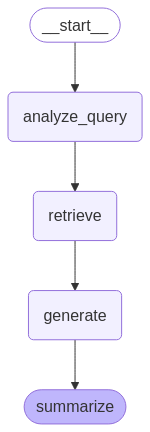

In [54]:
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

## Test conversation

In [101]:
result = graph.invoke({"question": "Can you tell me if Beiersdorf conducts animal testing?",
                       "chat_history": chat_history})

print(f'Metadata: {result["query"]["company"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')

Metadata: Beiersdorf
Context: [Document(metadata={'company': 'Beiersdorf', 'topic': 'ethics', 'source_file': 'beiersdorf_ethics.json', '_id': 5, '_collection_name': 'demo_collection'}, page_content='certified cruelty-free brand by PETA or the Leaping Bunny program, as its compliance with Chinese regulations means some products may still be subject to animal testing in specific markets. However, the company is a member of the European Partnership for Alternative Approaches to Animal Testing (EPAA), reflecting its investment in non-animal research methods. **Labor Conditions:** Beiersdorf adheres to international labor standards and is a member of the United Nations Global Compact, committing to fair labor practices, human rights, and anti-corruption measures. The company’s 2022 Sustainability Report highlights initiatives to ensure safe working conditions, fair wages, and employee development programs across its supply chain. Independent audits, such as those by the Sedex Members Ethica

In [102]:
result = graph.invoke({"question": "Can you tell me about any of the companies environmental policies?",
                       "chat_history": chat_history})

print(f'Metadata: {result["query"]["company"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')

Metadata: Beiersdorf
Context: [Document(metadata={'company': 'Beiersdorf', 'topic': 'environment', 'source_file': 'beiersdorf_env.json', '_id': 0, '_collection_name': 'demo_collection'}, page_content="Beiersdorf, the German multinational company behind brands like Nivea, Eucerin, and La Prairie, has made significant commitments to environmental sustainability, which are outlined in its official reports and verified by independent sources. The company's sustainability strategy, 'Care Beyond Skin,' focuses on reducing its environmental footprint across its value chain, including climate action, sustainable packaging, and responsible sourcing. Climate Action: Beiersdorf has set ambitious climate targets aligned with the Science-Based Targets initiative (SBTi). The company aims to reduce its Scope 1 and 2 greenhouse gas (GHG) emissions by 30% by 2025 and achieve net-zero emissions by 2045. As of its 2022 Sustainability Report, Beiersdorf reduced its carbon emissions from operations by 64% 

In [103]:
result = graph.invoke({"question": "Can you tell me about Loreals environmental policies?",
                       "chat_history": chat_history})

print(f'Metadata: {result["query"]["company"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')

Metadata: L'Oréal
Context: [Document(metadata={'company': "L'Oréal", 'topic': 'ethics', 'source_file': 'loreal_ethics.json', '_id': 15, '_collection_name': 'demo_collection'}, page_content="The company was also named in a 2023 EU greenwashing investigation for misleading 'natural origin' claims. Perhaps most troubling is evidence that L'Oréal, through its membership in Cosmetics Europe, has lobbied against stricter chemical regulations according to a 2022 InfluenceMap report - a stance seemingly at odds with its public sustainability commitments. Independent ratings reflect these contradictions: Ecovadis grants L'Oréal its highest Platinum Rating, while Ethical Consumer gives a poor 4/20 score citing animal testing and supply chain concerns. The 2023 Beauty Sustainability Index ranked L'Oréal 12th among 55 major brands, praising its initiatives while noting implementation gaps. In conclusion, while L'Oréal demonstrates sector-leading policies in some areas, significant ethical challeng